# Feature Practice - CWRU

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import hilbert
import z_dependancy as z_dep
plt.rc('font', size=20)

# 데이터 로드

## 회전 주파수 알아보기

In [2]:
F_shaft_rpm = 1797
F_shaft = F_shaft_rpm/60
print('Shaft Frequency is', F_shaft)

Shaft Frequency is 29.95


## 베어링 주파수 DB 만들기

In [3]:
F_BPFI = 5.4152
F_BPFO = 3.5848
F_FTF = 0.398
F_BSF = 4.7135

F_BPFI_w = F_BPFI*F_shaft
F_BPFO_w = F_BPFO*F_shaft
F_FTF_w = F_FTF*F_shaft
F_BSF_w = F_BSF*F_shaft

print('Outer Race Fault Frequency is', F_BPFO_w)

Outer Race Fault Frequency is 107.36476


## 신호 로드하고 그려보기

In [4]:
fs=12000

### 신호를 로드해 주세요. 
정상 데이터를 v_n, 결함 데이터를 v_f로 지정해 주세요

In [5]:
data = np.array(pd.read_csv('./data/data_normal.csv'))
v_n = data[:,1]

data = np.array(pd.read_csv('./data/data_fault.csv'))
v_f = data[:,1]






### 정상, 고장 신호를 한 그래프에 그려주세요

(-4.0, 4.0)

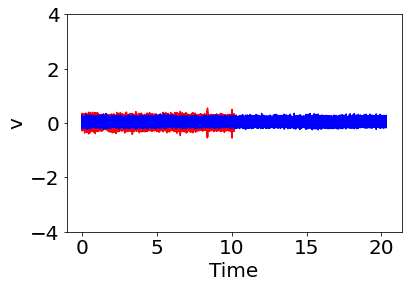

In [6]:
T_n = len(v_n)/fs               # 전체 샘플수 / 1초당 샘플수 = 총 시간
t_n=np.arange(1/fs, T_n, 1/fs)  # 1/fs초 부터 T초까지 1/fs초 간격
T_f = len(v_f)/fs
t_f = np.arange(1/fs, T_f, 1/fs)

plt.figure()
plt.plot(t_f,v_f,'r')
plt.plot(t_n,v_n,'b')
plt.xlabel('Time')
plt.ylabel('v')
plt.ylim([-4,4])





## 주파수 분석해보기

### 정상, 고장 신호에 대해 주파수 분석을 한 후 한 그래프에 그려주세요

(0.0, 0.06)

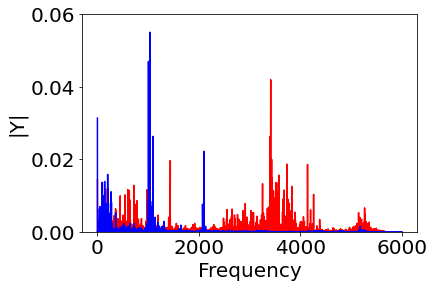

In [7]:
f_n, A_n = z_dep.z_fft_simple(v_n,fs)
f_f, A_f = z_dep.z_fft_simple(v_f,fs)

plt.figure()
plt.plot(f_f,A_f,'r')
plt.plot(f_n,A_n,'b')
plt.xlabel('Frequency')
plt.ylabel('|Y|')
plt.ylim([0,0.06])




### 정상, 고장 신호에 대해 필터링을 수행해 주세요.

In [8]:
ftype='band'
Wn=np.array([2500,4500])
print(Wn)

[2500 4500]


정상신호에 대한 결과는 v_filter_n, 결함신호에 대한 결과는 v_filter_f 라는 변수로 지정해 주세요.

In [9]:
v_filter_n = z_dep.filtering(v_n, fs, Wn, ftype)
v_filter_f = z_dep.filtering(v_f, fs, Wn, ftype)






### 정상, 고장 신호에 대해 주파수 분석을 한 후 한 그래프에 그려주세요

(-2.0, 2.0)

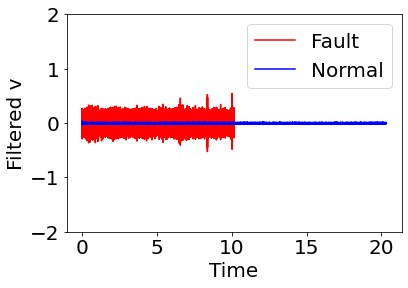

In [10]:
plt.figure()
plt.plot(t_f,v_filter_f,'r')
plt.plot(t_n,v_filter_n,'b')
plt.xlabel('Time')
plt.ylabel('Filtered v')
plt.legend(['Fault','Normal'])
plt.ylim([-2,2])

## 필터링 포락선 분석해보기

### 정상, 고장 신호의 필터링 결과에 대해 포락선 분석을 수행해 주세요.
정상신호에 대한 결과는 v_filter_env_n, 결함신호에 대한 결과는 v_filter_env_f 라는 변수로 지정해 주세요.

In [11]:
v_filter_env_n = abs(hilbert(v_filter_n,axis=0));
v_filter_env_f = abs(hilbert(v_filter_f,axis=0));






In [12]:
[f_filter_env_n, A_filter_env_n] = z_dep.z_fft_simple(v_filter_env_n-np.mean(v_filter_env_n),fs);
[f_filter_env_f, A_filter_env_f] = z_dep.z_fft_simple(v_filter_env_f-np.mean(v_filter_env_f),fs);

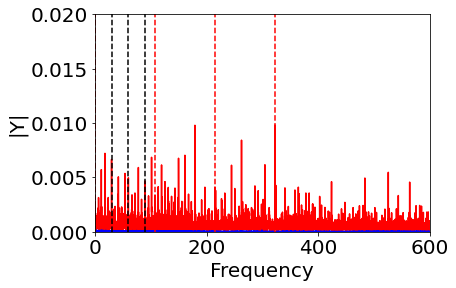

In [13]:
plt.figure()
plt.plot(f_filter_env_f,A_filter_env_f,'r')
plt.plot(f_filter_env_n,A_filter_env_n,'b')
plt.xlabel('Frequency')
plt.ylabel('|Y|')
plt.axis([0,600,0,0.02])

for n in range(4):
    plt.axvline(n*F_shaft, color='k', linestyle='dashed')
    plt.axvline(n*F_BPFO_w, color='r', linestyle='dashed')

# Feature 추출

In [14]:
band_energy_and_filter = [2000,4500]
band_enrgy_from_envelope = np.matrix([
                [F_BPFO_w*0.9, F_BPFO_w*1.1],
                [2*F_BPFO_w*0.9, 2*F_BPFO_w*1.1],
                [3*F_BPFO_w*0.9, 3*F_BPFO_w*1.1]
                ])

print(f'Band Energy and Filter Range: {band_energy_and_filter}')
print(f'Band Energy from Envelope: {band_enrgy_from_envelope}')

Band Energy and Filter Range: [2000, 4500]
Band Energy from Envelope: [[ 96.628284 118.101236]
 [193.256568 236.202472]
 [289.884852 354.303708]]


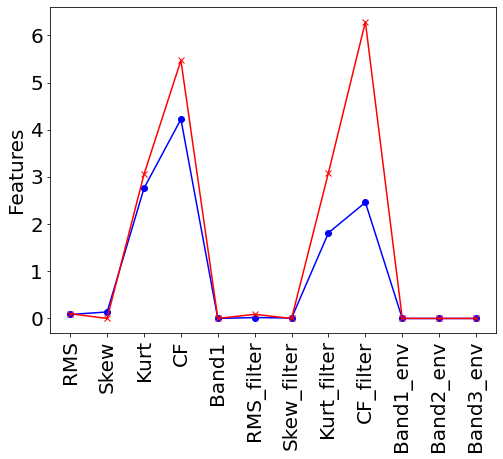

In [20]:
feature_n, feature_name = z_dep.z_feature(v_n, fs, band_energy_and_filter, band_enrgy_from_envelope)
feature_f, feature_name = z_dep.z_feature(v_f, fs, band_energy_and_filter, band_enrgy_from_envelope)

plt.figure(figsize=(8,6))
plt.plot(feature_n,'-bo')
plt.plot(feature_f,'-rx')
plt.xticks(np.arange(0,np.size(feature_name)),feature_name,rotation='vertical')
plt.ylabel('Features')
plt.show()

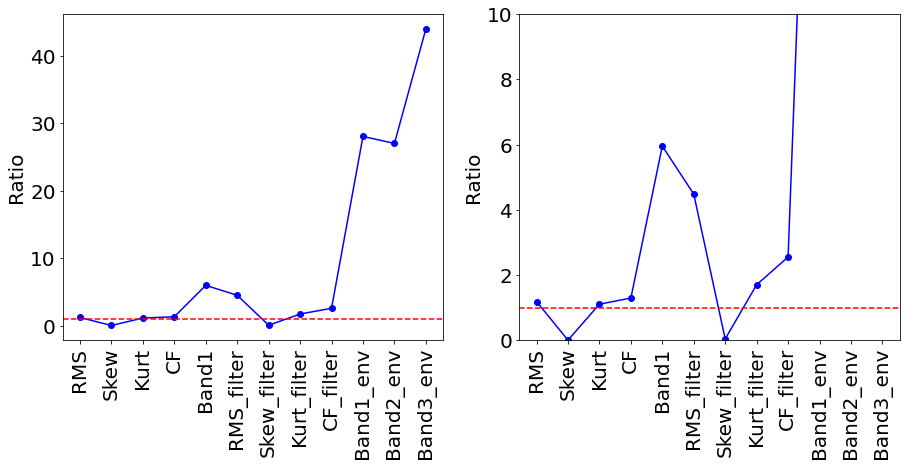

In [23]:
feature_ratio = feature_f/feature_n

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(feature_ratio,'-bo')
plt.xticks(np.arange(0,np.size(feature_name)),feature_name,rotation='vertical')
plt.axhline(y=1, color='r', linestyle='--')
plt.ylabel('Ratio')

plt.subplot(1,2,2)
plt.plot(feature_ratio,'-bo')
plt.xticks(np.arange(0,np.size(feature_name)),feature_name,rotation='vertical')
plt.axhline(y=1, color='r', linestyle='--')
plt.ylim([0,10])
plt.ylabel('Ratio')
plt.show()